In [1]:
import datetime
import logging
import sys
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec
from tqdm import tqdm
from utils.forecast import get_dwd_forecast

# sys.path.append("/".join(sys.path[0].split("/")[:-1]))

from studies.utils.forecast import get_dwd_forecast
from studies.utils.dwd_data import DWD_Dataset, Feature

In [2]:
FIG_SAVE_BASE_PATH = "../docs/report/fig/"
DOUBLE_COL_FIG_SIZE = (15, 5)

In [3]:
dataset_model_1 = DWD_Dataset(source_path="../data/dwd", feature=Feature.PRECIPITATION, model=1)
dataset_model_2 = DWD_Dataset(source_path="../data/dwd", feature=Feature.PRECIPITATION, model=2)

First look at one specific station

In [5]:
STATION_ID = 257

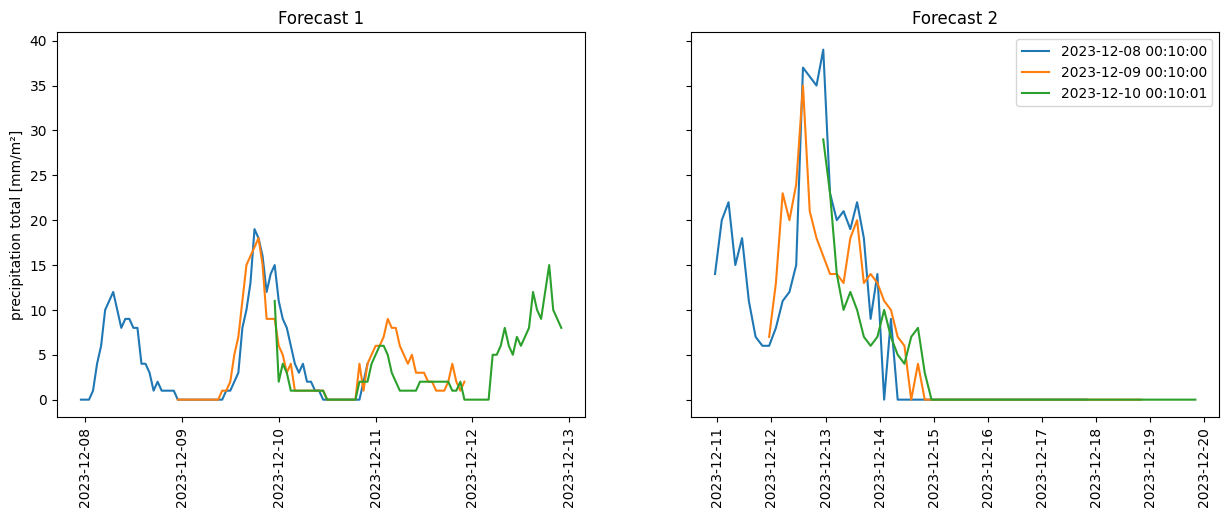

In [6]:
forecast1 = dataset_model_1.get_forecast(station_id=STATION_ID)
forecast2 = dataset_model_2.get_forecast(station_id=STATION_ID)


fig, axs = plt.subplots(ncols=2, sharey=True, figsize=DOUBLE_COL_FIG_SIZE)
for call_time in sorted(forecast1["call_time"].unique())[1:4]:
    sub_df_forecast = forecast1[forecast1["call_time"] == call_time]
    t = sub_df_forecast["time"]
    values = sub_df_forecast["precipitation_forecast"]
    axs[0].plot(t, values, label=call_time)
    
    sub_df_forecast = forecast2[forecast2["call_time"] == call_time]
    t = sub_df_forecast["time"]
    values = sub_df_forecast["precipitation_forecast"]
    axs[1].plot(t, values, label=call_time)

axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=90)
axs[0].set_title("Forecast 1")
axs[0].set_ylabel("precipitation total [mm/m²]")
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=90)
axs[1].set_title("Forecast 2")
axs[1].legend()

fig.savefig(FIG_SAVE_BASE_PATH + "precipitation_forecast.pdf")

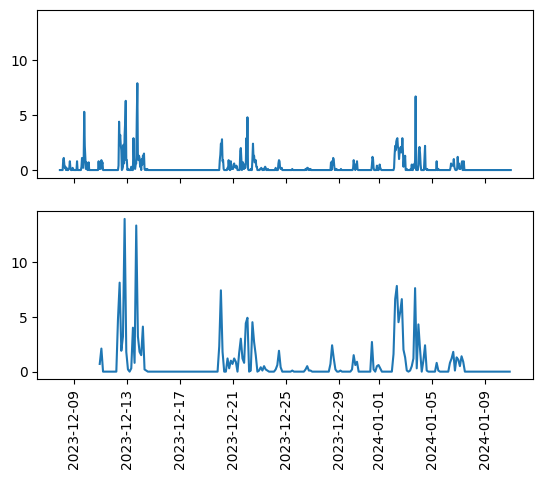

In [10]:


fig, axs = plt.subplots(nrows=2, sharex=True, sharey=True)
real_data = dataset_model_1.get_merge(station_id=STATION_ID).sort_values(by="time")
axs[0].plot(real_data["time"], real_data["precipitation_real"])
real_data = dataset_model_2.get_merge(station_id=STATION_ID).sort_values(by="time")
axs[1].plot(real_data["time"], real_data["precipitation_real"])

axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=90)


Text(0.5, 0.98, 'Difference: Precipitation Forecast and Historical Precipitation for station: 257')

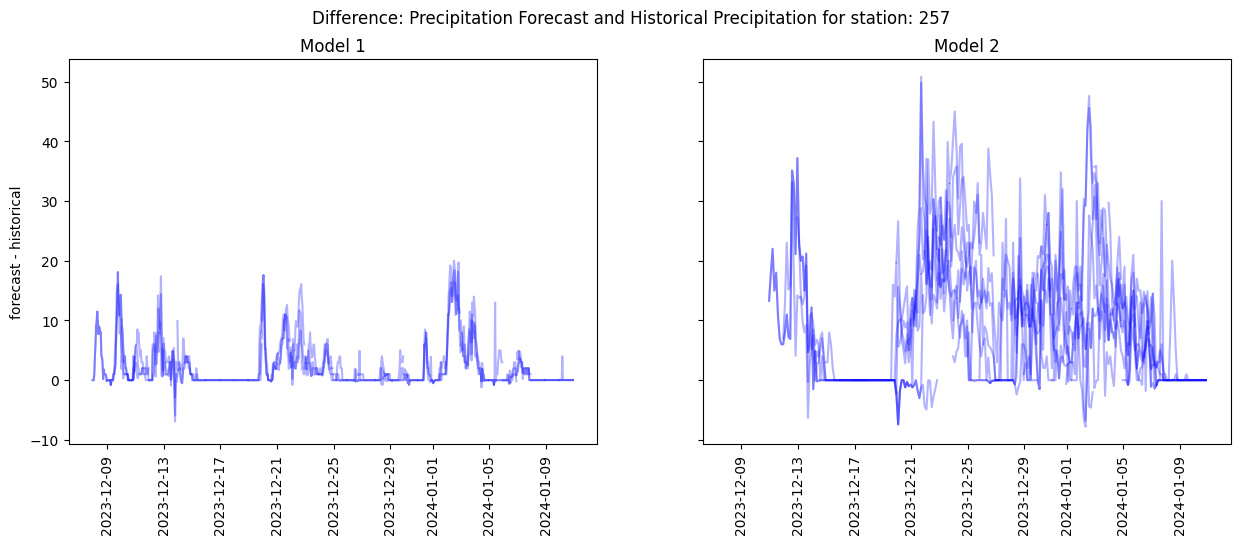

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=DOUBLE_COL_FIG_SIZE, sharey=True)
merge1 = dataset_model_1.get_merge(station_id=STATION_ID)
merge2 = dataset_model_2.get_merge(station_id=STATION_ID)

# fig, ax1 = plt.subplots()

api_call_times = sorted(merge1["call_time"].unique())
num_api_calls = len(api_call_times)
for idx, call_time in enumerate(api_call_times):
    sub_df_forecast = merge1[merge1["call_time"] == call_time]
    t = sub_df_forecast["time"]
    error = sub_df_forecast["precipitation_error"]
    ax1.plot(t, error, c="b", alpha=0.3)
    

    sub_df_forecast = merge2[merge2["call_time"] == call_time]
    t = sub_df_forecast["time"]
    error = sub_df_forecast["precipitation_error"]
    ax2.plot(t, error, c="b", alpha=0.3)
    
ax1.set_xticks(ax1.get_xticks(), ax1.get_xticklabels(), rotation=90)
ax2.set_xticks(ax2.get_xticks(), ax2.get_xticklabels(), rotation=90)
ax1.set_ylabel("forecast - historical")
ax1.set_title("Model 1")
ax2.set_title("Model 2")
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation for station: " + str(STATION_ID))

What is the general trend of the error in  model 1  and model 2

In [13]:
merge1 = dataset_model_1.get_merge()

call_times = sorted(merge1["call_time"].unique())
station_ids = sorted(merge1["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge1[(merge1["call_time"] == call_time) & (merge1["station_id"] == station_id)]
        
        if len(sub_df_forecast) < 72:
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"].values[:72])
    
    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_1 = np.stack(result)



In [14]:
merge2 = dataset_model_2.get_merge() 

call_times = sorted(merge2["call_time"].unique())
station_ids = sorted(merge2["station_id"].unique())
result = []
for call_time in call_times:
    call_time_result = []
    for station_id in station_ids:
        sub_df_forecast = merge2[(merge2["call_time"] == call_time) & (merge2["station_id"] == station_id)]
        
        if len(sub_df_forecast) < 56:  # 56 is how many samples are expected in a forecast of model 2
            continue
        call_time_result.append(sub_df_forecast["precipitation_error"][:56])
    
    if not call_time_result:
        continue
    result.append(np.stack(call_time_result))
error_mat_model_2 = np.stack(result)

(26, 36, 56)
coef:  [ 6.76510125 -0.07759605]


Text(0.5, 1.0, 'Model 2')

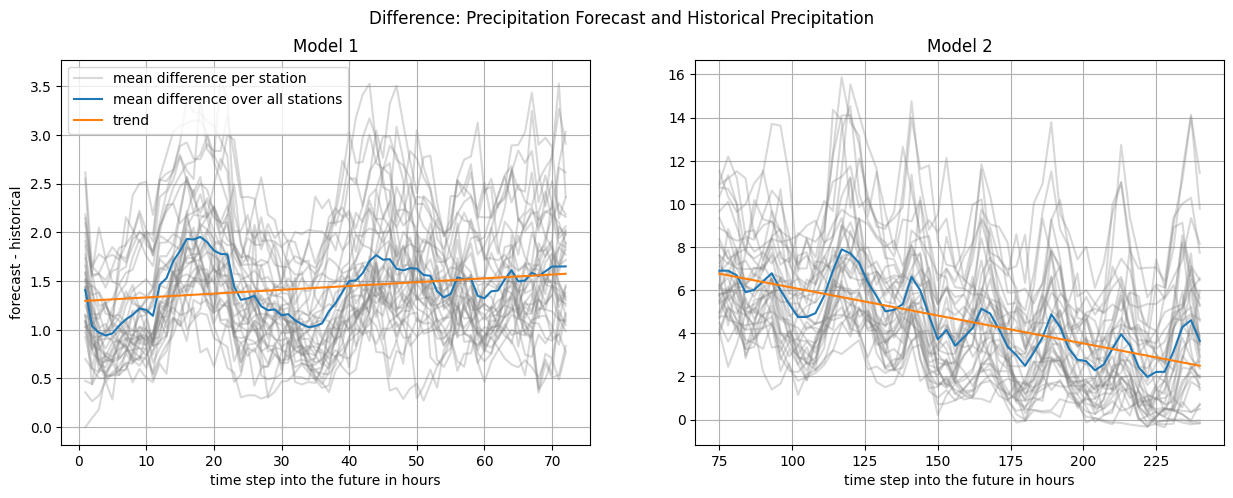

In [17]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=DOUBLE_COL_FIG_SIZE, sharey=False)
fig.suptitle("Difference: Precipitation Forecast and Historical Precipitation ")

# MODEL 1

station_errors = error_mat_model_1.mean(axis=0)
x_axis = np.arange(1, station_errors.shape[-1] + 1)

for idx, station_error in enumerate(station_errors):
    ax1.plot(x_axis, station_error, label="mean difference per station" if idx == 0 else "", color="grey", alpha=0.3)
forecast_error = station_errors.mean(axis=0)
ax1.plot(x_axis, forecast_error, label="mean difference over all stations")

# extract trend
x = np.arange(station_errors.shape[-1])[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
regression_coef = np.linalg.inv(x_aug.T @ x_aug) @ x_aug.T @ forecast_error
regression = x_aug @ regression_coef

ax1.plot(x_axis, regression, label="trend")

ax1.grid()
ax1.legend()
ax1.set_ylabel("forecast - historical")
ax1.set_title("Model 1")
ax1.set_xlabel("time step into the future in hours")


# MODEL 2
print(error_mat_model_2.shape)
station_errors = error_mat_model_2.mean(axis=0)
x_axis = (np.arange(1, station_errors.shape[-1] + 1) * 3) + 72

for idx, station_error in enumerate(station_errors):
    ax2.plot(x_axis, station_error, label="mean difference per station" if idx == 0 else "", color="grey", alpha=0.3)
forecast_error = station_errors.mean(axis=0)
ax2.plot(x_axis, forecast_error, label="mean difference over all stations")

# extract trend
x = np.arange(station_errors.shape[-1])[:, None]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
regression_coef = np.linalg.inv(x_aug.T @ x_aug) @ x_aug.T @ forecast_error
regression = x_aug @ regression_coef

ax2.plot(x_axis, regression, label="trend")

ax2.grid()
ax2.set_xlabel("time step into the future in hours")
print("coef: ", regression_coef)

ax2.set_title("Model 2")

# TODO: ask if we would use bar plots -> h

get confidence intervalls of the mean curve (blue) with bootstrap

In [16]:
# do bootstrapping for each time step into the future and therefor get a confidence internal around the mean error
N_BOOT = 10000


flatten_errors_1 = np.concatenate(error_mat_model_1, axis=0)
flatten_errors_2 = np.concatenate(error_mat_model_1, axis=0)
N_1 = len(flatten_errors_1)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means = np.empty((flatten_errors_1.shape[1], N_1))
for time_step_error in tqdm(flatten_errors_1.T):
    simulated_errors = np.random.choice(time_step_error, size=(N_BOOT, N_1), replace=True)
    boot_strap_means.append(simulated_errors.mean(axis=1))

boot_strap_means = np.stack(boot_strap_means)


  0%|          | 0/72 [00:00<?, ?it/s]


AttributeError: 'numpy.ndarray' object has no attribute 'append'

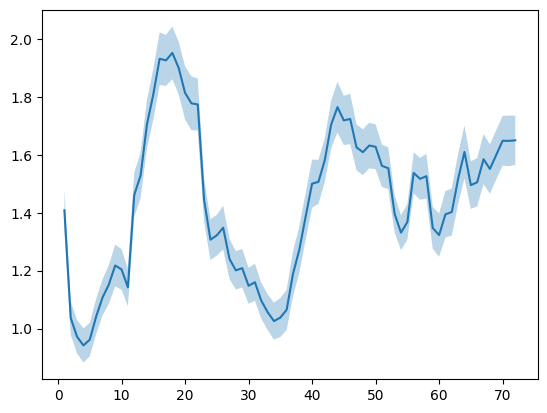

In [ ]:
fig, ax = plt.subplots()
x_axis = np.arange(1, 73)
mean = boot_strap_means.mean(axis=1)
std = boot_strap_means.std(axis=1)

ax.plot(x_axis, mean)
ax.fill_between(x_axis, mean - std, mean + std, alpha=0.3)

# TODO: ellipse plots???? 


look at the covariance between the estimated mean and the estimated standard variance. 

array([[153.28137403,   8.01215628],
       [  8.01215628,   0.42218414]])

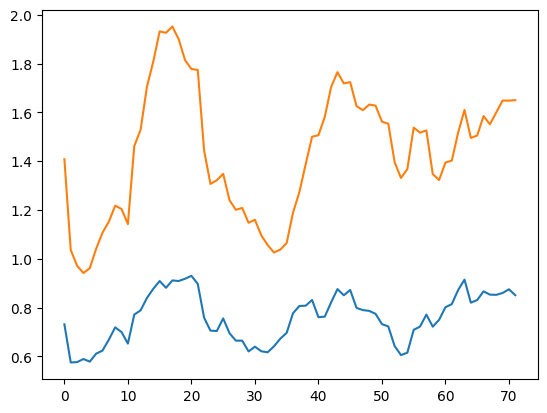

In [ ]:
fig, ax = plt.subplots()

ax.plot(std * 10)
ax.plot(mean)

estimator_properties = np.stack([mean, std]).T
estimator_properties.T @ estimator_properties

NameError: name 'q811' is not defined

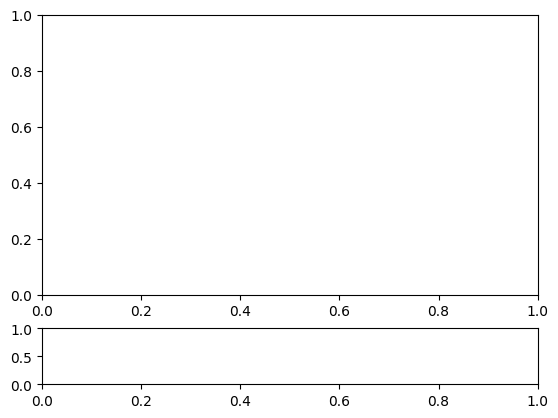

In [ ]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1,height_ratios=[5,1])
ax1 = fig.add_subplot(gs[1])
ax0 = fig.add_subplot(gs[0], sharex=ax1)
axs = [ax0, ax1]

min_time = datetime(9999, 1, 1, 0, 0)
max_time = datetime(1, 1, 1, 0)
for call_time in sorted(q811["call_time"].unique())[1:]:
    api_call = q811[q811["call_time"] == call_time]
    
    sorted_df = api_call[["time", "precipitationTotal"]].sort_values(by=["time"])
    # print(sorted_df)
    axs[0].plot(sorted_df["time"], sorted_df["precipitationTotal"], alpha=0.3)
    left = min(sorted_df["time"])
    right = max(sorted_df["time"])
    axs[1].plot((left, right), (call_time, call_time))

    if left < min_time:
        min_time = left
    if right > max_time:
        max_time = right

plt.setp(ax0.get_xticklabels(), visible=False)
day_labels = [dt._text.split(" ")[0] for dt in axs[1].get_xticklabels()[::24]]
axs[1].set_xticks(axs[1].get_xticks()[::24], day_labels, rotation=90)

axs[0].set_ylabel("Predicted total precipitation")
axs[1].set_xlabel("Forecast for time")
axs[1].set_ylabel("Time of forecast")

print(min_time, max_time)

In [ ]:
hourly = df[df["provider"] == "DWD_1"]
q811 = hourly[hourly["station_id"] == "Q811"]



fig = plt.figure()
gs = gridspec.GridSpec(2, 1,height_ratios=[5,1])
ax1 = fig.add_subplot(gs[1])
ax0 = fig.add_subplot(gs[0], sharex=ax1)
axs = [ax0, ax1]

min_time = datetime(9999, 1, 1, 0, 0)
max_time = datetime(1, 1, 1, 0)
for call_time in sorted(q811["call_time"].unique())[1:]:
    api_call = q811[q811["call_time"] == call_time]
    
    sorted_df = api_call[["time", "precipitationTotal"]].sort_values(by=["time"])
    # print(sorted_df)
    axs[0].plot(sorted_df["time"], sorted_df["precipitationTotal"], alpha=0.3)
    left = min(sorted_df["time"])
    right = max(sorted_df["time"])
    axs[1].plot((left, right), (call_time, call_time))

    if left < min_time:
        min_time = left
    if right > max_time:
        max_time = right

plt.setp(ax0.get_xticklabels(), visible=False)
day_labels = [dt._text.split(" ")[0] for dt in axs[1].get_xticklabels()[::24]]
axs[1].set_xticks(axs[1].get_xticks()[::24], day_labels, rotation=90)

axs[0].set_ylabel("Predicted total precipitation")
axs[1].set_xlabel("Forecast for time")
axs[1].set_ylabel("Time of forecast")

print(min_time, max_time)

NameError: name 'df' is not defined

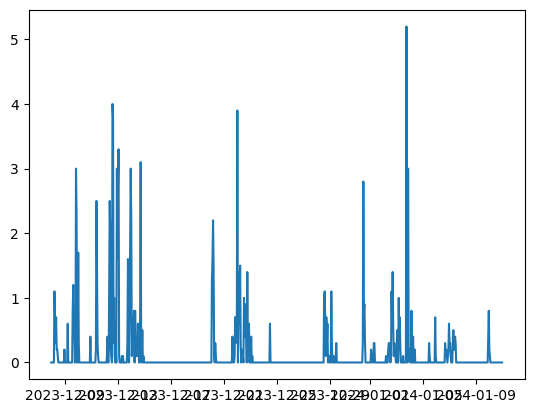

In [ ]:
# find station id to Stationskennung Q811
import pandas as pd

from studies.utils.recent import get_recent
from project.process.utils.download_dwd_data import FEATURE_STATION_PROPERTY_MAP
import glob

stations_df = pd.read_csv("../data/dwd/stations.tsv", sep="\t")

station_id = stations_df[stations_df["Stations-kennung"] == "Q811"]["Stations_ID"].unique()[0]


# load real data for station_id
property = "precipitation"
recent_df = get_recent(feature=property)
recent_df = recent_df.rename(columns={"MESS_DATUM": "time"})
recent_df = recent_df[recent_df["STATIONS_ID"] == station_id]
recent_df = recent_df[["STATIONS_ID", "time", "  R1"]]
recent_df = recent_df[recent_df["time"] >= min_time]
recent_df = recent_df[recent_df["time"] <= max_time]

# plot recent precipitation
fig, ax = plt.subplots()
ax.plot(recent_df["time"], recent_df["  R1"])

Here I want ot calculate the errors of a prediction

In [ ]:
# load prediction
provider = "DWD_1"
station_id = "Q811"
self._feature = "precipitationTotal"

In [ ]:
forecasts = get_dwd_forecast(self._feature)
forecasts = forecasts[forecasts["provider"] == provider]
# forecasts = forecasts[forecasts["station_id"] == station_id]
recent = get_recent("precipitation")
stations = pd.read_csv("../data/dwd/stations.tsv", sep="\t")

def get_station_id(stations_kennung: str):
    station_id = list(stations[stations["Stations-kennung"] == stations_kennung]["Stations_ID"].unique())[0]
    return station_id

forecasts["station_id"] = forecasts["station_id"].apply(get_station_id)

In [ ]:
from studies.utils.forecast import set_errors_to_zeros


recent = recent.rename(columns={"MESS_DATUM": "time", "STATIONS_ID": "station_id"})
recent["  R1"] = recent["  R1"].apply(set_errors_to_zeros)
merge1 = pd.merge(forecasts, recent, on=["time", "station_id"], how="left")
merge1 = merge1.assign(error=lambda x: x['precipitationTotal'] - x['  R1'])
# exclude station_id=1239
merge1 = merge1[merge1["station_id"] != 1239]

Text(0.5, 0, 'Datetime of comparison')

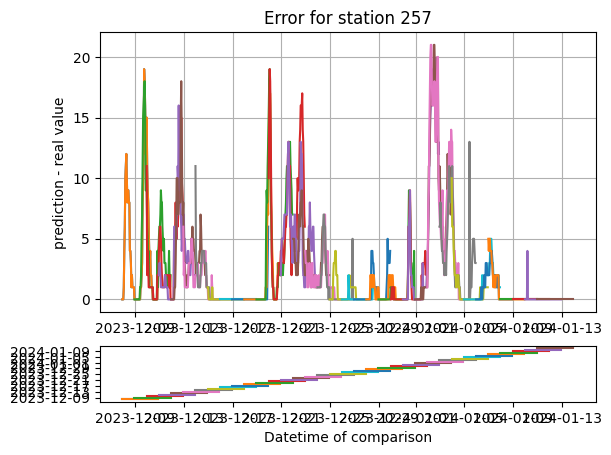

In [ ]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1,height_ratios=[5,1])
ax1 = fig.add_subplot(gs[1])
ax0 = fig.add_subplot(gs[0], sharex=ax1)
axs = [ax0, ax1]

station_id = 257
axs[0].set_title(f"Error for station {station_id}")
for call_time in sorted(forecasts["call_time"].unique()):
    call_time_forecast = merge1[(merge1["call_time"] == call_time) & (merge1["station_id"] == station_id)]
    forecast_time = call_time_forecast["time"]
    axs[0].plot(forecast_time, call_time_forecast["precipitationTotal"])
    axs[1].plot((min(forecast_time), max(forecast_time)), (call_time, call_time))

axs[0].grid()
axs[0].set_ylabel("prediction - real value")
axs[1].set_xlabel("Datetime of comparison")

We can obsever in this plot that the error is basically greater than zero. This means the forecast is more prone to predict more rain than in real life

In [ ]:
errors = []
station_ids = merge1["station_id"].unique()

for call_time in sorted(merge1["call_time"].unique()):
    same_call_time = merge1[merge1["call_time"] == call_time]
    call_time_errors = []
    for station_id in station_ids:
        call_time_error = same_call_time[same_call_time["station_id"] == station_id]["error"].values
        call_time_error = call_time_error[:72]  # This is a HACK and needs to be resolved
        call_time_errors.append(call_time_error)
    errors.append(np.stack(call_time_errors))
    time = same_call_time["time"].values 

# shape: (num_api_calls, num_stations, num_predictions_into_future)
errors = np.stack(errors)
num_errors_per_call_time = np.isnan(errors).sum(axis=2).sum(1)
print(num_errors_per_call_time)
# print(list(zip(merge["call_time"].unique(), num_errors_per_call_time)))
# errors = np.abs(errors)
# ax.plot(x, np.stack(errors).mean(axis=0))
"""fig, ax = plt.subplots()
for call_time_error in errors:
    for station_error in call_time_error:
        ax.plot(station_error, alpha=1/np.sqrt(len(errors) + len(call_time_error)), color="grey", label="individual station")
mean_error = np.concatenate(errors, axis=0).mean(axis=0) 
ax.plot(mean_error, label="mean")
ax.set_ylabel("predicted precipitation - real precipitation")
ax.set_xlabel("time steps into the future")"""

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  805 1645 2485]


'fig, ax = plt.subplots()\nfor call_time_error in errors:\n    for station_error in call_time_error:\n        ax.plot(station_error, alpha=1/np.sqrt(len(errors) + len(call_time_error)), color="grey", label="individual station")\nmean_error = np.concatenate(errors, axis=0).mean(axis=0) \nax.plot(mean_error, label="mean")\nax.set_ylabel("predicted precipitation - real precipitation")\nax.set_xlabel("time steps into the future")'

Do a permutation test for the whole error.  
H0: The forecast is not prone to overestimate nor underestimate precipitation 

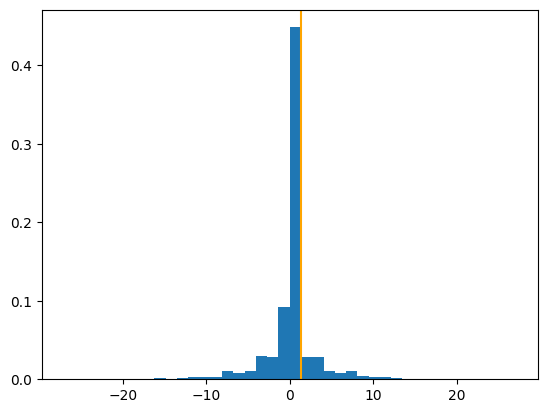

In [ ]:
from sklearn.utils import shuffle

prediction = merge1["precipitationTotal"].values
real = merge1["  R1"].values

# exclude nan values
mask = np.isnan(prediction) + np.isnan(real)
prediction = prediction[~mask]
real = real[~mask]
mean_error = (prediction - real).mean()

data = np.concatenate([prediction, real])
scrambled = shuffle(data)
scrambled = np.stack([scrambled[:len(prediction)], scrambled[len(prediction):]])
error = scrambled[0] - scrambled[1]

fig, ax = plt.subplots()
hist, bins = np.histogram(error, bins=40, density=True)
ax.hist(error, bins=40, density=True)
ax.axvline(mean_error, color="orange")


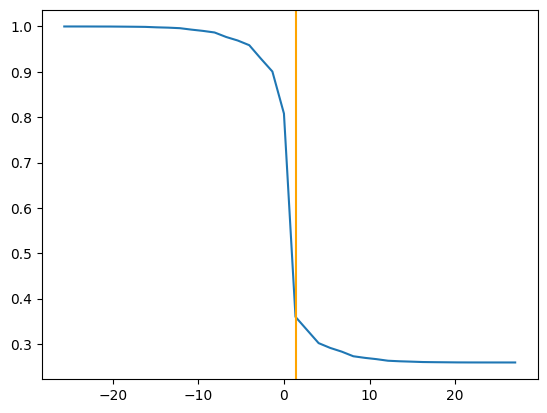

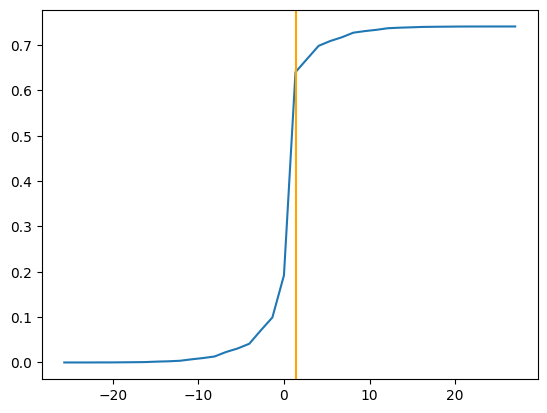

In [ ]:
fig, ax = plt.subplots()
ax.plot(bins[1:], 1- hist.cumsum())
ax.axvline(mean_error, color="orange")

fig, ax = plt.subplots()
ax.plot(bins[1:], hist.cumsum())
ax.axvline(mean_error, color="orange")


IS one location espacially prone for errors?


In [ ]:
errors = np.stack(errors)
fig, ax = plt.subplots()
for station_id, station_error in zip(station_ids, errors.swapaxes(0, 1)):
    ax.plot(np.mean(station_error, axis=0), c="gray", alpha=0.3)

ax.plot(np.mean(station_error, axis=0), c="gray", alpha=0.3, label="station mean error")

mean_error = errors.mean(axis=0)
mean_error = mean_error.mean(axis=0)
ax.plot(mean_error, label="meanerror")

# line fitting
mask = np.isnan(mean_error)
x = np.arange(72)[:, None][~mask]
x_aug = np.concatenate([np.ones_like(x), x], axis=1)
covariance = x_aug.T @ x_aug
regression_coef = np.linalg.inv(x_aug.T @ x_aug) @x_aug.T @ mean_error[~mask]

fit = x_aug @ regression_coef
ax.plot(x, fit, label="linear regression")
ax.legend()
ax.set_xlabel("prediction step into the future")
ax.set_ylabel("prediction - real")

NameError: name 'errors' is not defined

In [ ]:
# do bootstrapping for each time step into the future and therefor get a confidence internal around the mean error
N_BOOT = 10000
N = len(flatten_errors)  # The idea is to draw random samples with replacement from the original dataset, and the sample size influences the variability of the estimates.
boot_strap_means = []
for time_step_error in tqdm(errors.swapaxes(0, 2)):
    flatten_errors = time_step_error.flatten()
    simulated_errors = np.random.choice(flatten_errors, size=(N_BOOT, N), replace=True)
    boot_strap_means.append(simulated_errors.mean(axis=1))

boot_strap_means = np.stack(boot_strap_means)


100%|██████████| 72/72 [00:05<00:00, 12.53it/s]


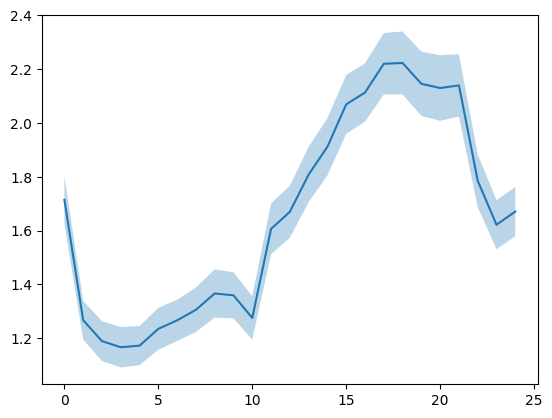

In [ ]:
fig, ax = plt.subplots()
stds = np.std(boot_strap_means, axis=1)

ax.plot(mean_error)
ax.fill_between(np.arange(72), mean_error - stds, mean_error + stds, alpha=0.3)

IS one location espacially prone for errors?

Compute correlation between error and time to forecast?
Can we observe the same thing for temperature?

Can we do somehow bootstrapping?


given the amount of predicted precipitation whats the expected error 

Compute on average divergence for a forecast into the future. 
Observer how a forecast changes over time

